# **<span style="color: #8181FF">Simulation pour déterminer la fréquence nécessaire de mise à jour</span>**

*Fonctionne avec Python 3.10.9 (Anaconda 23.3.1).*

In [1]:
# Bibliothèques de base
import pandas as pd
import numpy as np

# Visualisations
import matplotlib.pyplot as plt

# Pour normaliser et encoder les données
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Utilisé pour le modèle de clustering
from sklearn import cluster

# Utilisé pour comparer les clusters
from sklearn.metrics import adjusted_rand_score

# Pour mesurer les durées des fits et de l'exécution du notebook
import time

- Mesure de la durée d'exécution du notebook.

In [2]:
t_notebook = time.time()

## **Importation du dataset**

In [3]:
data = pd.read_excel("data_global.xlsx")

## **Définition des fonctions qui seront utilisées**

- Pour mettre scaler les variables numériques et encoder les variables catégorielles

In [4]:
def scale_and_encode(features, data):
    """
    Cette fonction sert à scaler les données numériques et à encoder les variables catégorielles.

    - features : features à utiliser
    - data : données à utiliser
    - Retourne X, les features choisies scalées/encodées
    """

    # Sélection des variables numériques
    numeric_features = data[features].select_dtypes(include=['number']).columns.tolist()
    # Sélection des variables catégorielles
    categorical_features = data[features].select_dtypes(exclude=['number']).columns.tolist()

    # Sélection des données
    X = data.loc[:, features]

    # Instanciation du sscaler
    numeric_transformer = StandardScaler()
    # Instanciation de l'encoder
    categorical_transformer = OneHotEncoder(sparse_output=False)

    feature_encoder = ColumnTransformer(
        transformers=[
            (
                'cat',
                categorical_transformer,
                categorical_features
                ),
            (
                'num',
                numeric_transformer,
                numeric_features
                )
            ]
        )
    X = feature_encoder.fit_transform(X)

    return X

- Mesure de la stabilité dans le temps.

In [5]:
def delta_ari(delta=1, duree_initiale=12, clusters=5, tableau=True):
    """
    Cette fonction calcule le score ARI entre les étiquettes calculées sur la période initiale
    et les étiquettes calculées quand des données sont ajoutée

    delta_choisi : tous les combien de mois faire la comparaison
    duree_initiale : durée en mois couverte par la pérdiode initiale
    tableau : afficher les valeurs dans un tableau (True/False)
    """

    # Calcul, en mois, de la période couverte par le dataset
    period_months = (data['first_purchase_date'].max() - data['first_purchase_date'].min()).days / 30.44  # Jours moyens dans un mois
    print(f"Période totale couverte par le dataset : {period_months:.2f} mois")
    initiale = duree_initiale
    print(f"Taille choisie pour la période initiale : {initiale} mois.")

    # Nombre de clusters que le modèle devra retourner
    biskmean_cluster_nb = clusters

    # Création du dataset couvrant la période initiale
    start_date_initial = data['first_purchase_date'].min().replace(day=1)
    end_date_initial = start_date_initial + pd.DateOffset(months=initiale)
    end_date_initial = end_date_initial.replace(day=pd.to_datetime(end_date_initial).days_in_month)
    data_initial = data[(data['first_purchase_date'] >= start_date_initial) & (data['first_purchase_date'] < end_date_initial)].copy()
    # Puisque nous avons un nouveau segment temporel, nous devons recalculer les variables recency et frequency
    data_initial['recency'] = (data_initial['last_purchase_date'].max() - data_initial['last_purchase_date']).dt.days
    data_initial['frequency'] = (data_initial['last_purchase_date'].max() - data_initial['first_purchase_date']).dt.days / data_initial['orders_number']

    # Entraînement du modèle sur la période initiale
    X_scaled__initial = scale_and_encode(features=features_list, data=data_initial)
    X_model = X_scaled__initial
    clust_bis = cluster.BisectingKMeans(
        n_clusters=biskmean_cluster_nb,
        init='k-means++',
        random_state=19,
        n_init=1,
        bisecting_strategy='biggest_inertia'
        )
    clust_bis.fit(X_model)
    labels_initial = clust_bis.labels_
    data_initial['Clusters_Initiaux'] = labels_initial

    # Tous les combien de mois on souhaite tester
    delta_choisi = delta
    print("Delta choisi pour le suivi :", delta_choisi, "mois.")

    # Les scores ARI calculés à chaque période seront stockés dans cette liste
    scores_ARI = []

    # La première période (à ajouter à la période initiale) sera égale à delta_choisi
    periode = delta_choisi

    # Entrainement du modèle pour chaque période et comparaison des labels obtenus avec les labels calculés avec la période initiale
    for i in range(int((period_months - duree_initiale) / delta_choisi)):
        # Création de la période, qui contiendra les données de la période initiale
        # + ajout à chaque itération des données sur une pérdiode de delta_choisi
        # Donc, première itération : données de période initiale + delta_choisi
        # 2ème itération : données de la période initiale + delta_choisi * 2
        # et ainsi de suite jusqu'à ce qu'on soit arrivé à la fin du dataset
        start_date = data['first_purchase_date'].min().replace(day=1)
        end_date = start_date + pd.DateOffset(months=duree_initiale) + pd.DateOffset(months=periode)
        end_date = end_date.replace(day=pd.to_datetime(end_date).days_in_month)
        data_periode = data[(data['first_purchase_date'] >= start_date) & (data['first_purchase_date'] < end_date)].copy()
        # Puisque nous avons un nouveau segment temporel, nous devons recalculer les variables recency et frequency
        data_periode['recency'] = (data_periode['last_purchase_date'].max() - data_periode['last_purchase_date']).dt.days
        data_periode['frequency'] = (data_periode['last_purchase_date'].max() - data_periode['first_purchase_date']).dt.days / data_periode['orders_number']

        # Entraînement du modèle sur la période en cours
        X_scaled_periode = scale_and_encode(features=features_list, data=data_periode)
        X_model = X_scaled_periode
        clust_bis = cluster.BisectingKMeans(
            n_clusters=biskmean_cluster_nb,
            init='k-means++',
            random_state=19,
            n_init=1,
            bisecting_strategy='biggest_inertia'
            )
        clust_bis.fit(X_model)
        labels_periode = clust_bis.labels_
        data_periode['Clusters_periode'] = labels_periode

        # Clusters des clients initiaux, calculés avec les données de la période initiale
        a = data_initial['Clusters_Initiaux']

        # Clusters des clients initiaux, calculés avec les données de la période en cours
        b = data_periode.loc[data_periode['first_purchase_date'] <= data_initial['first_purchase_date'].max()]['Clusters_periode']

        # Ajout du score ARI calculé
        scores_ARI.append([periode, adjusted_rand_score(a, b)])

        # Préparation de la valeur periode pour l'itération suivante
        periode += delta_choisi

    # Création d'un dataframe avec les scores ARI pour chaque delta_choisi
    scores_ARI = pd.DataFrame(scores_ARI, columns=["Mois", "Score ARI"])

    # Affichage optionnel du dataframe avec les scores ARI
    if tableau == True:
        display(scores_ARI)

    # Tracé de la courbe des scores ARI
    fig, ax = plt.subplots(figsize=(12, 8))

    plt.grid(
        True,
        linestyle='--',
        color='gray',
        linewidth=0.5,
        )
    
    ax.plot(
        scores_ARI["Mois"],
        scores_ARI["Score ARI"],
        marker='o',
        markersize=10,
        linestyle='-',
        color="#8181FF",
        linewidth=3,
        )

    # paramétrage de l'axe x en fonction de delta_choisi
    ax.set_xticks(range(delta_choisi, periode, delta_choisi))
    ax.set_xlim(delta_choisi, periode-delta_choisi)

    plt.title(f'\nÉvolution des clusters au cours du temps\nen comparaison avec la période initiale ({duree_initiale} mois)\n', fontsize=25)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax.set_xlabel("\nMois\n", fontsize=25)
    ax.set_ylabel("\nScore ARI\n", fontsize=25)

    plt.show()

## **Choix des features à utiliser avec le modèle.**

- Choix des features.

In [6]:
features_list = [
    #'customer_lat',
    #'customer_lng',
    'orders_number',
    #'first_purchase_date',
    #'last_purchase_date',
    'recency',
    'frequency',
    #'avg_spent',
    'total_spent',
    #'preferred_payment_type',
    #'avg_payment_installments',
    #'shipping_fees_proportion',
    #'avg_customer_seller_distance_km',
    'avg_delivery_time',
    #'preferred_category',
    'avg_review_score',
]

## **Objectif**

Nous voulons tester la stabilité du modèle dans le temps.<br>
Comme nous ne pouvons pas prédire les données qui seront ajoutées au dataset dans le futur, nous allons revenir dans le passé.<br>
Je vais d'abord entraîner le modèle sur les clients d'une pérdiode initiale. Chacun de ces clients se verra attribué une étiquette de cluster.<br>
Je vais ensuite réentraîner le modèle en ajoutant successivement des données et regarder l'évolution des étiquettes attribuées aux clients de la période initiale.<br>
Pour comparer les étiquettes, je vais utiliser l'indice de Rand ajusté (Adjusted Rand Score, ARI).

## **Stabilité du modèle dans le temps**

Période totale couverte par le dataset : 22.83 mois
Taille choisie pour la période initiale : 14 mois.
Delta choisi pour le suivi : 1 mois.


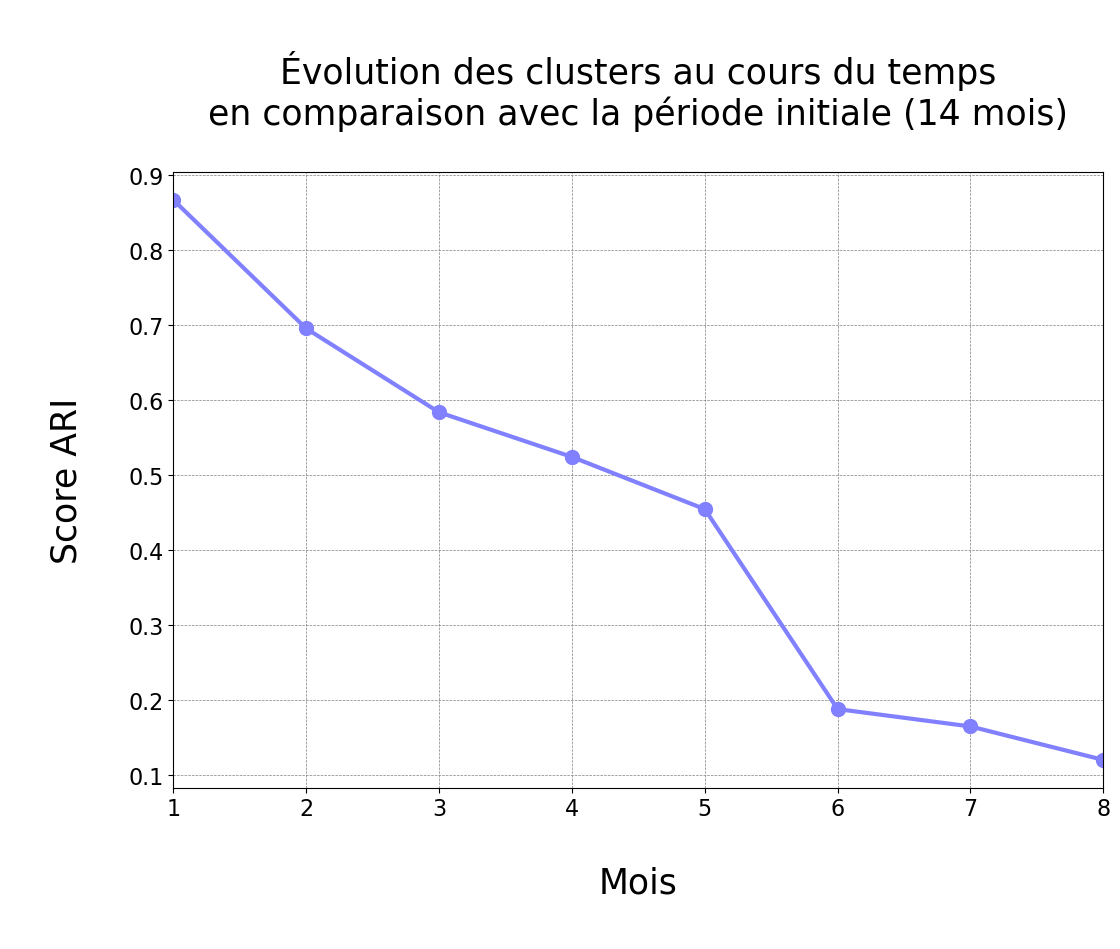

In [7]:
delta_ari(delta=1, duree_initiale=14, clusters=5, tableau=False)

**Le score ARI descend rapidement. Le mieux serait de réentraîner le modèle tous les mois.**

- Affichage de la durée d'exécution du notebook.

In [8]:
temps_secondes = time.time() - t_notebook

# Conversion en minutes et secondes
minutes = int(temps_secondes // 60)
seconds = int(temps_secondes % 60)

# Formatage du résultat
formatted_time = f"{minutes:02}:{seconds:02}"

print(f"Durée d'exécution du notebook (hors imports) : {formatted_time}")

Durée d'exécution du notebook (hors imports) : 00:23
